In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import csv
import glob
from scipy.ndimage import gaussian_filter1d
from scipy.integrate import solve_ivp
from ipywidgets import interact, FloatSlider, Layout, interactive


$\text{If we are given that the molecular weight of the protein is "Z" Da and if we also know that the volume of the droplet is } X \, \mu \text{L}$

$\text{then we can find out the number of protein molecules. We already know from before what the protein concentration is at every time value.}$ 

$\text{The protein concentration will be labeled as "Y". The first step is to find out the mass of the protein at every different time value}$

$\text{Mass of the protein} = \frac{Y\text{ng}}{\mu \text{L}} \times X \, \mu \text{L} = X \, Y \, \text{ng}$

$\text{The second step is to identiy the definition of 1 Da: }$

$1 \, \text{Da} = \frac{1 \, \text{g}}{\text{mol}} = \frac{1 \, \text{ng}}{\text{nmol}}$

$\text{The third step is to calculate the number of protein molecules: }$

$\text{number of protein molecules} = \left( \frac{1 \, \text{nmol}}{Z \, \text{ng}} \right) \left( X \, Y \, \text{ng} \right) \left( 6 \times 10^{14} \, \frac{\text{molecules}}{1 \, \text{nmol}} \right)$

$ = \frac{6 \times 10^{14} XY}{Z}$

where $X$ is the droplet volume in $\mu L$, $Y$ is the protein concentration in $\frac{ng}{\mu L}$, and $Z$ is the atomic weight in $\frac{g}{mol}$




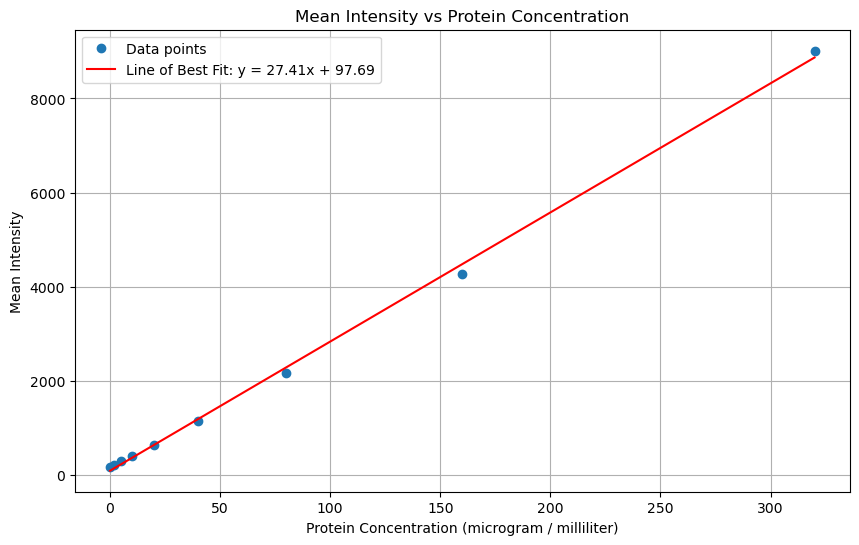

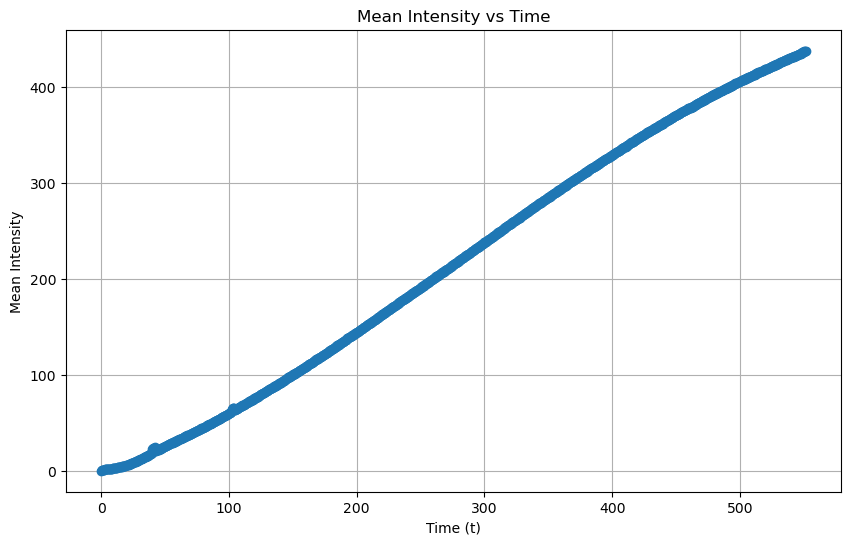

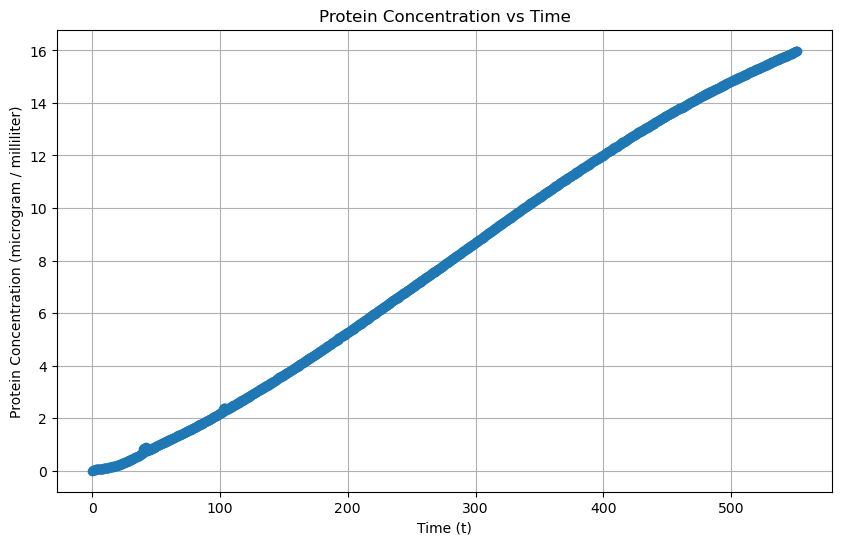

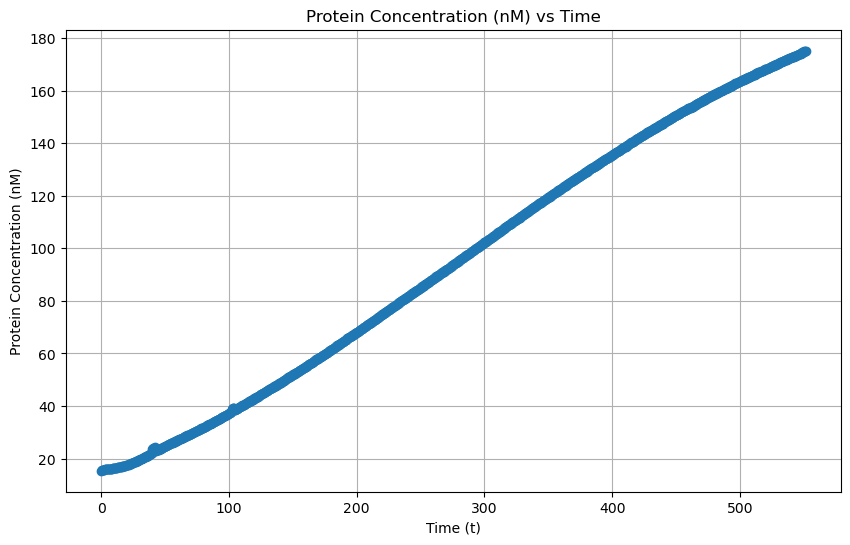

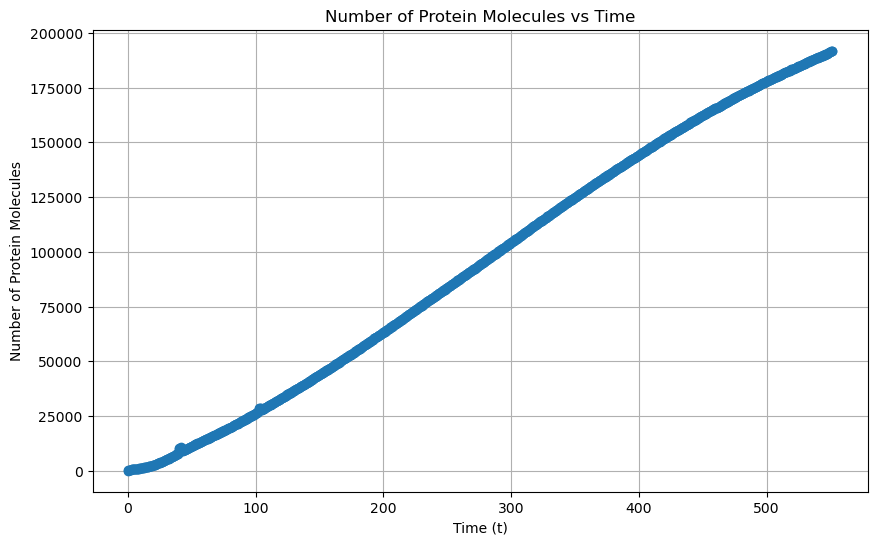

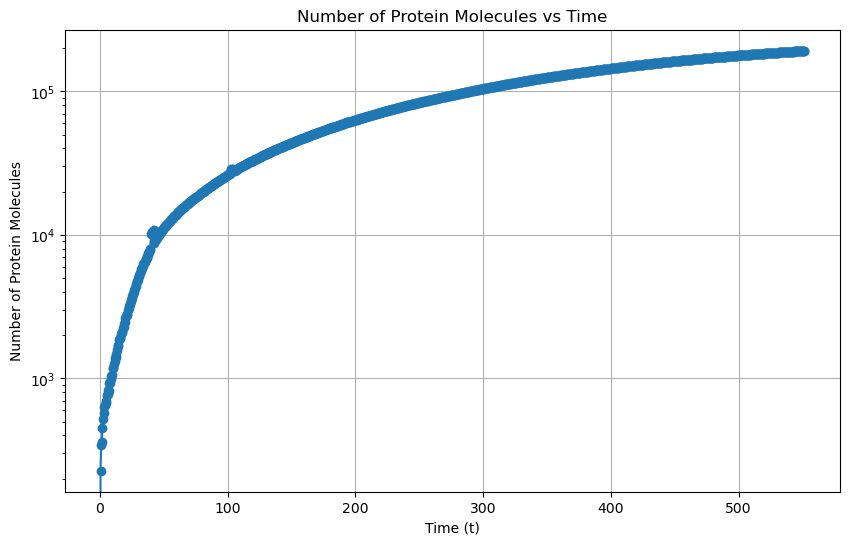

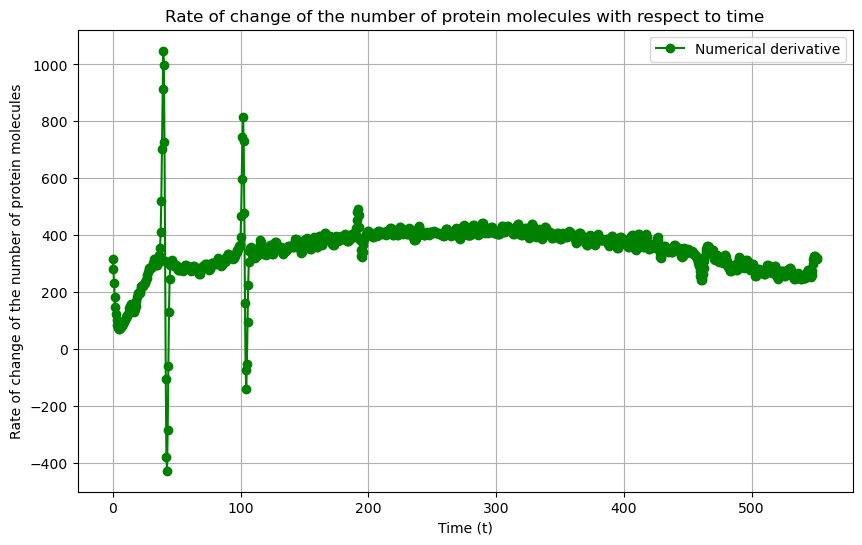

In [53]:

timeValues_List = list()
meanIntensity_List = list()
meanIntensity_CalibrationCurve_List = list()
proteinConcentration_List = list()
proteinConcentration_nM_List = list()
numberOfProteinMolecules_List = list()
rateOfChangeProteinMolecules_List = list()

# This function utilizes the images taken for the experiment of the K401 motor protein
def calculateMeanIntensity(paths):
    for i in range(0, len(paths)): 
        # Load the image as a matrix
        image_path = paths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_List.append(meanIntensity)

# This function utilizes 9 sample images to analyze the relationship between "Mean Intensity" and "Protein Concentration"
def getConcentration(calibrationCurvePaths, mw_kda): # This function takes a list of image paths and molecular weight in kDa as arguments
    for i in range(0, len(calibrationCurvePaths)):
        # Load the image as a matrix
        image_path = calibrationCurvePaths[i]
        image_matrix = io.imread(image_path)
        meanIntensity = image_matrix.mean()
        meanIntensity_CalibrationCurve_List.append(meanIntensity) 

    df = pd.DataFrame(meanIntensity_CalibrationCurve_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Protein Concentration (microgram / milliliter)", 0:"Mean Intensity"})
    sampleConcentration_Values = [0, 2, 5, 10, 20, 40, 80, 160, 320]
    df["Protein Concentration (microgram / milliliter)"] = sampleConcentration_Values

    # Get the equation (linear) of best fit for the Protein Concentration
    x = df["Protein Concentration (microgram / milliliter)"]
    y = df["Mean Intensity"]

    slope, intercept = np.polyfit(x, y, 1) # Multiple return values is allowed in Python
    
    line_of_best_fit = slope * x + intercept
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df["Protein Concentration (microgram / milliliter)"], df["Mean Intensity"], marker='o', linestyle='none', label='Data points')
    plt.plot(x, line_of_best_fit, label=f'Line of Best Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
    plt.title('Mean Intensity vs Protein Concentration')
    plt.xlabel('Protein Concentration (microgram / milliliter)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Transform the dependent variables
    for i in range(0, len(meanIntensity_List)):
        proteinConcentration = (meanIntensity_List[i] - intercept) / slope
        proteinConcentration_List.append(proteinConcentration)
        proteinConcentration_nM = ((proteinConcentration * 1e-3) / (mw_kda * 1e3)) * 1e9 # Convert to nM
        proteinConcentration_nM_List.append(proteinConcentration_nM)

def constructDataFrames(timeInterval):
    global meanIntensity_List
    global proteinConcentration_List
    global proteinConcentration_nM_List

    minimumIntensityValue = min(meanIntensity_List)
    adjustedMeanIntensity_List = [x - minimumIntensityValue for x in meanIntensity_List] # Subtract the minimum mean intensity value from ALL values
    meanIntensity_List = adjustedMeanIntensity_List

    minimumProteinConcentration = min(proteinConcentration_List)
    adjustedProteinConcentration_List = [x - minimumProteinConcentration for x in proteinConcentration_List]
    proteinConcentration_List = adjustedProteinConcentration_List

    df = pd.DataFrame(meanIntensity_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Mean Intensity"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Mean Intensity'], marker='o')
    plt.title('Mean Intensity vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Mean Intensity')
    plt.grid(True)
    plt.show()

    df2 = pd.DataFrame(proteinConcentration_List).reset_index()
    df2 = df2.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nanogram / microliter)"})
    df2["Time (min)"] = df2["Time (min)"] * timeInterval # Manipulate the "time" values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df2['Time (min)'], df2['Protein Concentration (nanogram / microliter)'], marker='o')
    plt.title('Protein Concentration vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (microgram / milliliter)')
    plt.grid(True)
    plt.show()

    df3 = pd.DataFrame(proteinConcentration_nM_List).reset_index()
    df3 = df3.rename(columns={"index":"Time (min)", 0:"Protein Concentration (nM)"})
    df3["Time (min)"] = df3["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(df3['Time (min)'], df3['Protein Concentration (nM)'], marker='o')
    plt.title('Protein Concentration (nM) vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Protein Concentration (nM)')
    plt.grid(True)
    plt.show()

def getNumberOfProteinMolecules(dropletVolume, timeInterval, mw_kda):
    global numberOfProteinMolecules_List
    proteinMass_List = [i * dropletVolume for i in proteinConcentration_List] # List comprehension technique
    numberOfProteinMolecules_List = [(j * 6e14) / (mw_kda * 1e3) for j in proteinMass_List] # This expression was derived from several intermediate calculations

    df = pd.DataFrame(numberOfProteinMolecules_List).reset_index() # Create a data frame 
    df = df.rename(columns={"index":"Time (min)", 0:"Number of Protein Molecules"})
    df["Time (min)"] = df["Time (min)"] * timeInterval # Manipulate the "time" values

    # Plot the data

    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df['Time (min)'], df['Number of Protein Molecules'], marker='o')
    plt.title('Number of Protein Molecules vs Time')
    plt.xlabel('Time (t)')
    plt.ylabel('Number of Protein Molecules')
    # y axis log scale
    plt.yscale('log')
    plt.grid(True)
    plt.show()

def getRateOfChangeProteinMolecules(timeInterval):
    global timeValues_List
    global rateOfChangeProteinMolecules_List
    
    p_vals = np.array(numberOfProteinMolecules_List) # Converts a Python list to a numpy array
    length = len(numberOfProteinMolecules_List)
    maxTimeValue = (length - 1) * timeInterval 
    t_vals = np.linspace(0, maxTimeValue, length) # Creates a numpy array
    timeValues_List = t_vals.tolist()

    # Estimate the numerical derivative of the number of protein molecules with respect to time
    dp_dt = np.gradient(p_vals, t_vals)
    rateOfChangeProteinMolecules_List = dp_dt.tolist()

    # apply gaussian filter with sigma 2
    dp_dt = gaussian_filter1d(dp_dt, sigma=2)
    
    # Plot the estimated derivative
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, dp_dt, label='Numerical derivative', marker='o', color="green")
    plt.xlabel('Time (t)')
    plt.ylabel('Rate of change of the number of protein molecules')
    plt.title('Rate of change of the number of protein molecules with respect to time')
    plt.legend()
    plt.grid(True)
    plt.show()

def saveData(fileName): # Saves the data to a CSV file
    # save dataframes to csv files
    dataFile = open(fileName, 'w', newline="")
    writerCSV = csv.writer(dataFile)
    headerRow = list()
    headerRow.append("Time")
    headerRow.append("Mean Intensity")
    headerRow.append("Protein Concentration (ng/µL)")
    headerRow.append("Protein Concentration (nM)")
    headerRow.append("Number of Protein Molecules (PM)")
    headerRow.append("Rate of Change of Number of PM")
    writerCSV.writerow(headerRow)
    for i in range(0, len(meanIntensity_List)):
        dataRow = list()
        dataRow.append(timeValues_List[i])
        dataRow.append(meanIntensity_List[i])
        dataRow.append(proteinConcentration_List[i])
        dataRow.append(proteinConcentration_nM_List[i])
        dataRow.append(numberOfProteinMolecules_List[i])
        dataRow.append(rateOfChangeProteinMolecules_List[i])
        writerCSV.writerow(dataRow)
    dataFile.close()

def runAnalysis(paths, calibrationCurvePaths, timeInterval, dropletVolume, mw_kda, fileName):
    calculateMeanIntensity(paths) # 1st function to be called
    getConcentration(calibrationCurvePaths, mw_kda) # 2nd function to be called
    constructDataFrames(timeInterval) # Time interval is passed in minutes. # 3th function to be called
    getNumberOfProteinMolecules(dropletVolume, timeInterval, mw_kda) # For the experiment of the K401 protein, the droplet had a volume of 2 microliters. 4th function to be called
    getRateOfChangeProteinMolecules(timeInterval) # 5th function to be called
    saveData(fileName) # 6th function to be called


paths = sorted(glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/k401-activedrops/img_*********_gfp-4x_000.tif"))
calibration_curve_paths = sorted(glob.glob("/Users/edgarlarios/Dropbox/SURF_activedrops/Edgar/calibration_curve/***ugml.tif"))

# The molecular weight must be passed in kDa, the volume of the droplet must be passed in microliters, and the time interval must be passed in minutes
runAnalysis(paths, calibration_curve_paths, 0.5, 0.000002, 100, "proteinsData.csv") # This is the analysis for the "k401" protein

# Comprehensive Guide to Cell-Free Protein Synthesis Model

## 1. Biological Background

In cell-free protein synthesis systems, we study the processes of transcription and translation outside of living cells. This allows us to examine these processes in a more controlled environment. The key components are:

1. DNA: The template for transcription
2. RNA Polymerase: Enzyme that transcribes DNA into mRNA
3. mRNA: The product of transcription and template for translation
4. Ribosomes: Molecular machines that translate mRNA into proteins
5. Amino Acids: Building blocks of proteins
6. Proteases: Enzymes that degrade proteins

The process flows as follows: DNA → mRNA → Protein, with protein degradation occurring simultaneously.

## 2. Model Parameters

- $k_{TX}$: Transcription rate [nucleotides/second]
- $k_{TL}$: Translation rate [amino acids/second]
- $N_m$: mRNA length [nucleotides]
- $N_p$: Protein length [amino acids]
- $\tau_m$: mRNA lifetime [seconds]
- $\tau_0$: Transcription delay [seconds]
- $\tau_f$: Protein folding delay [seconds]
- $R_p$: RNA polymerase concentration [nM]
- $R$: Ribosome concentration [nM]
- $K_{TL}$: Michaelis-Menten constant for translation [nM]
- $D$: DNA concentration [nM]
- $k_{deg}$: Protein degradation rate constant [1/second]
- $X_p$: Protease concentration [nM]
- $K_p$: Michaelis-Menten constant for degradation [nM]

## 3. Mathematical Model

### 3.1 mRNA Dynamics

The rate of change of mRNA concentration is given by:

$$\frac{dm}{dt} = k_{TX}N_m^{-1}[R_p]D - \frac{m(t)}{\tau_m}, \quad \forall t > \tau_0$$

#### Dimensional Analysis:
- $\frac{dm}{dt}$: [nM]/[s]
- $k_{TX}N_m^{-1}[R_p]D$: ([nt]/[s]) · (1/[nt]) · [nM] · [nM] = [nM]/[s]
- $\frac{m(t)}{\tau_m}$: [nM]/[s]

#### Solution:
Solving this differential equation (see mathematical steps in section 4), we get:

$$m(t) = m_{ss}(1 - e^{-(t - \tau_0)/\tau_m}), \quad \forall t > \tau_0$$

Where $m_{ss}$ is the steady-state mRNA concentration:

$$m_{ss} = k_{TX}N_m^{-1}[R_p]D\tau_m$$

### 3.2 Protein Synthesis

The rate of protein synthesis is:

$$\frac{dp_{syn}}{dt} = \frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f)$$

#### Dimensional Analysis:
- $\frac{dp_{syn}}{dt}$: [nM]/[s]
- $\frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f)$: ([aa]/[s]) · (1/[aa]) · [dimensionless] · [nM] = [nM]/[s]

### 3.3 Protein Degradation

The rate of protein degradation follows Michaelis-Menten kinetics:

$$\frac{dp_{deg}}{dt} = -\frac{k_{deg}[p]X_p}{K_p + [p]}$$

#### Dimensional Analysis:
- $\frac{dp_{deg}}{dt}$: [nM]/[s]
- $\frac{k_{deg}[p]X_p}{K_p + [p]}$: [1/s] · [nM] · [nM] / [nM] = [nM]/[s]

### 3.4 Overall Protein Dynamics

Combining synthesis and degradation:

$$\frac{dp}{dt} = \frac{k_{TL}N_p^{-1}}{1 + K_{TL}/R}m(t - \tau_f) - \frac{k_{deg}[p]X_p}{K_p + [p]}$$

## 4. Mathematical Steps

### Solving the mRNA dynamics equation:

1) Start with: $\frac{dm}{dt} = k_{TX}N_m^{-1}[R_p]D - \frac{m(t)}{\tau_m}$

2) Let $a = k_{TX}N_m^{-1}[R_p]D$ for simplicity: $\frac{dm}{dt} = a - \frac{m(t)}{\tau_m}$

3) Rearrange: $\frac{dm}{dt} + \frac{m(t)}{\tau_m} = a$

4) Multiply by integrating factor $e^{t/\tau_m}$: $e^{t/\tau_m}\frac{dm}{dt} + \frac{1}{\tau_m}e^{t/\tau_m}m(t) = ae^{t/\tau_m}$

5) Recognize as derivative: $\frac{d}{dt}(e^{t/\tau_m}m(t)) = ae^{t/\tau_m}$

6) Integrate: $e^{t/\tau_m}m(t) = a\tau_m e^{t/\tau_m} + C$

7) Solve for $m(t)$: $m(t) = a\tau_m + Ce^{-t/\tau_m}$

8) Apply initial condition $m(\tau_0) = 0$: $C = -a\tau_m e^{\tau_0/\tau_m}$

9) Final solution: $m(t) = a\tau_m(1 - e^{-(t-\tau_0)/\tau_m})$

10) Substitute back $a$: $m(t) = k_{TX}N_m^{-1}[R_p]D\tau_m(1 - e^{-(t-\tau_0)/\tau_m})$

### Deriving m_ss:

Set $\frac{dm}{dt} = 0$ in the original equation:

$0 = k_{TX}N_m^{-1}[R_p]D - \frac{m_{ss}}{\tau_m}$

Solve for $m_{ss}$: $m_{ss} = k_{TX}N_m^{-1}[R_p]D\tau_m$




In [ ]:
# More information about the mRNA dynamics equation


## Solving the mRNA Dynamics Equation

We start with the equation given in the paper:

$$\frac{dm}{dt} = k_{TX} \cdot N_m^{-1} \cdot [R_p D] - \frac{m(t)}{\tau_m}, \text{ for } t > \tau_0$$

## Step 1: Recognize the form of the equation

This is a first-order linear differential equation of the form:

$$\frac{dm}{dt} + Pm = Q$$

where $P = \frac{1}{\tau_m}$ and $Q = k_{TX} \cdot N_m^{-1} \cdot [R_p D]$

## Step 2: Set up the integrating factor

The integrating factor is:

$$e^{\int P dt} = e^{t/\tau_m}$$

## Step 3: Multiply both sides of the equation by the integrating factor

$$e^{t/\tau_m} \cdot \frac{dm}{dt} + e^{t/\tau_m} \cdot \frac{m}{\tau_m} = e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D]$$

## Step 4: Recognize the left side as the derivative of a product

$$\frac{d}{dt}(e^{t/\tau_m} \cdot m) = e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D]$$

## Step 5: Integrate both sides

$$\int d(e^{t/\tau_m} \cdot m) = \int e^{t/\tau_m} \cdot k_{TX} \cdot N_m^{-1} \cdot [R_p D] dt$$

## Step 6: Solve the integral

$$e^{t/\tau_m} \cdot m = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot e^{t/\tau_m} + C$$

## Step 7: Solve for m(t)

$$m(t) = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m + C \cdot e^{-t/\tau_m}$$

## Step 8: Apply the initial condition

At $t = \tau_0$, $m(\tau_0) = 0$

$$0 = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m + C \cdot e^{-\tau_0/\tau_m}$$
$$C = -k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot e^{\tau_0/\tau_m}$$

## Step 9: Substitute C back into the general solution

$$m(t) = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m \cdot (1 - e^{-(t-\tau_0)/\tau_m})$$

## Step 10: Simplify by recognizing m_ss

$$m_{ss} = k_{TX} \cdot N_m^{-1} \cdot [R_p D] \cdot \tau_m$$

Therefore, the final solution is:

$$m(t) = m_{ss} \cdot (1 - e^{-(t-\tau_0)/\tau_m}), \text{ for } t > \tau_0$$

This is the solution presented in the paper.




In [ ]:
# Here is the complete solution to the mRNA dynamics equation

$\frac{dm}{dt} = K_{TX} \cdot \frac{1}{N_m} \cdot \left[R_P D\right] - \frac{m}{\tau_m}$

$\frac{dm}{dt} + \frac{m}{\tau_m} = K_{TX} \cdot \frac{1}{N_m} \cdot \left[R_P D\right] = Q$

$\text{*** Note: Q is a constant and does not depend on time, t}$

$\text{Let } P(t) = {1 / \tau_m}, \text{ and let the integrating factor be: }$ $e^{\int \frac{dt}{\tau_m}} = e^{t / \tau_m}$

$\text{Now, we multiply both sides of the equation by the integrating factor:}$

$e^{t / \tau_m} \left( \frac{dm}{dt} + \frac{m}{\tau_m} \right) = Q e^{t / \tau_m}$


$\text{The left side of the equation can be viewed as the derivative of the product of two functions. Hence, due to the product rule, we have:}$

$\frac{d}{dt} \left[ m e^{t / \tau_m} \right] = e^{t / \tau_m} \left( \frac{dm}{dt} + \frac{m}{\tau_m} \right)$

$\therefore \frac{d}{dt} \left[ m e^{t / \tau_m} \right] = Q e^{t / \tau_m}$

$\text{Integrating both sides, we get:}$

$\int \frac{d}{dt} \left[ m e^{t / \tau_m} \right] dt = \int Q e^{t / \tau_m} dt$

$m e^{t / \tau_m} = \int Q e^{t / \tau_m} dt$

$\text{Dividing both sides by the integrating factor, we get:}$

$m = \frac{1}{e^{t / \tau_m}} \int Q e^{t / \tau_m} dt$


$\text{If we further simplify, we get:}$

$m = \frac{1}{e^{t / \tau_m}} \left[ Q \tau_m e^{t / \tau_m} + C \right]$

$m = Q \tau_m + \frac{C}{e^{t / \tau_m}}$ $\text{         This is the general solution.}$



$\text{To solve for } C, \text{ we use the fact that at } t = t_0, m(t_0) = 0:$

$0 = Q \tau_m + C e^{-t_0 / \tau_m}$

$\Rightarrow C = -Q \tau_m e^{t_0 / \tau_m}$

$\text{Hence, the final solution is:}$


$m = Q \tau_m - Q \tau_m e^{t_0 / \tau_m} e^{-t / \tau_m}$

$\text{If we further simplify, we get:}$

$m = Q \tau_m \left( 1 - e^{(t_0 - t) / \tau_m} \right)$   $\text{for } t \ge t_0$

$\text{The term } Q \tau_m \text{ is also known as } m_{ss}. \text{ Hence, the final solution can also be written this way:}$

$m = m_{ss} \left( 1 - e^{(t_0 - t) / \tau_m} \right) \text{ for } t \ge t_0$



In [ ]:
# Here is the complete solution to the protein dynamics equation

$\frac{dP}{dt} = \frac{K_{TL} \cdot \frac{1}{N_P}}{1+\frac{K_{TL}}{R}} \cdot m(t - \tau_f) - \frac{k_{deg} \cdot P \cdot X_P}{k_P + P}$

Let G = $\frac{K_{TL} \cdot \frac{1}{N_P}}{1+\frac{K_{TL}}{R}}$

$\text{Also, let } S = \text{constant} = k_{deg} \cdot X_P$

$\text{Thus, the ODE can be written in this simplified version:}$

$\frac{dP}{dt} = G m(t - \tau_f) - \frac{S P}{k_P + P}$

$\text{Previously, we found out that } m(t) \text{ is equal to:}$

$m(t) = Q \tau_m \left(1 - e^{(t_0 - t) / \tau_m}\right) \text{ for } t \ge t_0$

$\text{We can substitute this equation into the ODE; however, we must replace the variable } t \text{ with } t - \tau_f, \text{ since we have } m(t - \tau_f) \text{ in the ODE:}$

$\frac{dP}{dt} = G Q \tau_m \left(1 - e^{(t_0 - (t - \tau_f)) / \tau_m}\right) - \frac{S P}{k_P + P}$  $\text{ for } t \ge t_0 + \tau_f$

$\text{If we further simplify, we get:}$

$\frac{dP}{dt} = G Q \tau_m \left(1 - e^{(t_0 + \tau_f - t) / \tau_m}\right) - \frac{S P}{k_P + P}$  $\text{ for } t \ge t_0 + \tau_f$

$\text{Finally, if we change back the constants with the actual original parameters, we get:}$

$$\frac{dp}{dt} = \frac{k_{TL} \cdot k_{TX} \cdot [R_p] \cdot D \cdot \tau_m}{N_p \cdot N_m \left(1 + \frac{K_{TL}}{R}\right)} \left(1 - e^{-(t - \tau_f - \tau_0)/\tau_m}\right) - \frac{k_{deg} \cdot p \cdot X_p}{K_p + p} \quad \text{for} \quad t \ge \tau_0 + \tau_f$$

$\text{Observing the nature of this resulting ODE, it can be seen that the term } \frac{S P}{k_P + P} \text{ makes it very hard to solve this ODE}$

$\text{with separation of variables, because the variable } P \text{ appears in both the numerator and denominator of the fraction.}$

$\text{Also, if we tried to solve this ODE with the integrating factor technique, like so:}$

$\frac{dP}{dt} + \frac{S P}{k_P + P} = G Q \tau_m \left(1 - e^{(t_0 + \tau_f - t) / \tau_m}\right)$

$\text{this would be very hard to accomplish because the term } \frac{S P}{k_P + P} \text{ is non-linear. Finally, it is not obvious and straightforward that}$

$\text{other analytical methods could be used to solve this ODE. Thus, this ODE must be solved numerically using numerical methods}$

$\text{such as the Runge-Kutta method, or using software tools such as Python's } \texttt{scipy.integrate.solve\_ivp}.$




In [60]:
# Calculate the [R_p D] complex using the equation in the paper's supplementary information. 
def calculate_RpD(R_p, D, K_TX): # Accept parameters to calculate the [R_p D] complex
    return 0.5 * (R_p + D + K_TX - np.sqrt((R_p + D + K_TX)**2 - 4 * R_p * D))

# Define the differential equation for protein concentration
def dPdt(T, P, Q, S, tau_0, tau_f, k3, k11): # Not only accept the variables T and P. Also, accept parameters that will be treated as constants in the ODE.
    if T > tau_0 + tau_f:
        return Q * (1 - np.exp(-(T - tau_0 - tau_f) / k3)) - (S * P) / (k11 + P)
    else:
        return 0 

# Create a function to plot the oscillators with given parameters
def plot_proteinConcentration(k_TL, k_TX, R_p, D, tau_m, N_p, R, N_m, k_deg, X_p, K_p, tau_0, tau_f): #Parameters that will be able to be modified by the sliders
    
    RpD = calculate_RpD(R_p, D, k_TX) # For simplicity purposes, calculate [R_p D] complex using a function
    Q = (k_TL * k_TX * RpD * tau_m) / (N_p * (1 + k_TL / R) * N_m)  
    S = k_deg * X_p
    k3 = tau_m
    k11 = K_p

    # Time ranges from T = 0 to T = 5000 seconds
    T = np.linspace(0, 5000, len(proteinConcentration_nM_List)) # Same size as the experimental data of the protein concentration

    P_initial = 0  # At t = 0, the protein concentration P(0) = 0

    # All of the constants such as Q, S, tau_0... need to be passed as arguments into the solve_ivp()function
    p = solve_ivp(dPdt, [T[0], T[-1]], [P_initial], t_eval=T, args=(Q, S, tau_0, tau_f, k3, k11)) 
    
    plt.figure(figsize=(10, 6))
    plt.plot(T, proteinConcentration_nM_List, label='Experimental Curve', linestyle='--', color='orange')
    plt.plot(T, p.y[0], label='Theoretical Curve') # We need to access the "y" values from the object 'p' we created before
    plt.title('Protein Concentration vs. Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Protein Concentration (nM)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create interactive sliders for the parameters used to calculate the protein concentration

style = {'description_width': '300px'}  # Adjust the width as needed

interact(plot_proteinConcentration, 
         k_TL=FloatSlider(value=10.0 , min=1.0, max=20.0, step=0.1, description='k_TL (amino acids/s)', layout=Layout(width='900px'), style=style),
         k_TX=FloatSlider(value=1.0 , min=1.0, max=20.0, step=0.1, description='k_TX (rNTP/s)', layout=Layout(width='900px'), style=style),
         R_p=FloatSlider(value=30.0, min=20.0, max=40.0, step=1, description='RNA polymerase concentration (nM)', layout=Layout(width='900px'), style=style),
         D=FloatSlider(value=30.0, min=20.0, max=200.0, step=1, description='DNA concentration (nM)', layout=Layout(width='900px'), style=style),
         tau_m=FloatSlider(value=720.0 , min=300.0, max=1200.0, step=10.0, description='mRNA lifetime (seconds)', layout=Layout(width='900px'), style=style),
         N_p=FloatSlider(value=592, min=100, max=4500, step=100, description='protein length (amino acids)', layout=Layout(width='900px'), style=style),
         R=FloatSlider(value=190.0, min=50.0, max=350.0, step=10, description='ribosome concentration (nM)', layout=Layout(width='900px'), style=style),
         N_m=FloatSlider(value=3000, min=1500, max=4500, step=100, description='mRNA Length (Nucleotides)', layout=Layout(width='900px'), style=style),
         k_deg=FloatSlider(value=0.01, min=0.01, max=0.10, step=0.01, description='protein degradation rate constant (1/s)', layout=Layout(width='900px'), style=style),
         X_p=FloatSlider(value=9.0, min=1.0, max=20.0, step=1.0, description='protease concentration (nM)', layout=Layout(width='900px'), style=style),
         K_p=FloatSlider(value=4.0, min=1.0, max=20.0, step=1.0, description='Michaelis-Menten constant for degradation (nM)', layout=Layout(width='900px'), style=style),
         tau_0=FloatSlider(value=900.0, min=0.0, max=2000.0, step=10.0, description='transcription delay (seconds)', layout=Layout(width='900px'), style=style),
         tau_f=FloatSlider(value=60.0, min=0.0, max=300.0, step=1.0, description='protein folding delay (seconds)', layout=Layout(width='900px'), style=style))


interactive(children=(FloatSlider(value=10.0, description='k_TL (amino acids/s)', layout=Layout(width='900px')…

<function __main__.plot_proteinConcentration(k_TL, k_TX, R_p, D, tau_m, N_p, R, N_m, k_deg, X_p, K_p, tau_0, tau_f)>